This notebook calculates the direct damages to rail assets including climate change

In [16]:
# Imports
import configparser
from pathlib import Path
import pathlib
from direct_damages import damagescanner_rail_track as ds
import pandas as pd
import geopandas as gpd
import datetime
from ci_adapt_utilities import *
import pickle
import os

In [3]:
# Load configuration with ini file (created running config.py)
config_file=r'C:\repos\ci_adapt\config_ci_adapt.ini'
config = configparser.ConfigParser()
config.read(config_file)

p = Path('..')
hazard_type = config.get('DEFAULT', 'hazard_type')
infra_type = config.get('DEFAULT', 'infra_type')
country_code = config.get('DEFAULT', 'country_code')
country_name = config.get('DEFAULT', 'country_name')
hazard_data_subfolders = config.get('DEFAULT', 'hazard_data_subfolders')
asset_data = config.get('DEFAULT', 'asset_data')
vulnerability_data = config.get('DEFAULT', 'vulnerability_data')
data_path = Path(pathlib.Path.home().parts[0]) / 'Data'
interim_data_path = data_path / 'interim' / 'collected_flood_runs'

In [4]:
# Read vulnerability and maximum damage data from Nirandjan, S., et al. (2024)
curve_types = {'rail': ['F8.1']}
infra_curves, maxdams = ds.read_vul_maxdam(data_path, hazard_type, infra_type)
max_damage_tables = pd.read_excel(data_path / vulnerability_data / 'Table_D3_Costs_V1.0.0.xlsx',sheet_name='Cost_Database',index_col=[0])
print(f'Found matching infrastructure curves for: {infra_type}')

Found matching infrastructure curves for: rail


In [5]:
# Read hazard data (Rauthe M, et al. (2020): Climate impact analysis of the federal transport system in the context of floods: Final report of the key topic flood risks (SP-103) in topic area 1 of the BMVI expert network. 136 pages. DOI: 10.5675/ExpNRM2020.2020.04)
n_drive_dpath=Path(r'N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps')
hazard_data_list = ds.read_hazard_data(n_drive_dpath, hazard_type, country=country_name, subfolders=None)#hazard_data_subfolders)
print(f'Found {len(hazard_data_list)} hazard maps.')

Found 183 hazard maps.


In [6]:
# Read exposure data (OSM, OpenStreetMap contributors (2024) / osm-flex)
assets_path = data_path / asset_data
assets = gpd.read_file(assets_path)
assets = gpd.GeoDataFrame(assets).set_crs(4326).to_crs(3857)
assets = assets.loc[assets.geometry.geom_type == 'LineString']
assets = assets.rename(columns={'railway' : 'asset'})

# # Drop bridges and tunnels
# assets = assets.loc[~(assets['bridge'].isin(['yes']))]
# assets = assets.loc[~(assets['tunnel'].isin(['yes']))]

assets = assets[assets['railway:traffic_mode']!='"passenger"']
assets = assets.reset_index(drop=True)

# Add buffer to assets to do area intersect and create dictionaries for quicker lookup
buffered_assets = ds.buffer_assets(assets)
geom_dict = assets['geometry'].to_dict()
type_dict = assets['asset'].to_dict()

print(f"{len(assets)} assets loaded.")

##TODO: move all data preprocessing to different notebook (ie pre-prepared network)

117917 assets loaded.


In [7]:
# Calculate direct damage by asset (Koks. E.E. (2022). DamageScanner: Python tool for natural hazard damage assessments. Zenodo. http://doi.org/10.5281/zenodo.2551015)
# currently data with 3 baseline return periods: H=RP10, M=RP100, L=RP200
# TODO: for DEXX_RP, return period should be input or taken from dictionary/file names
# TODO: verify cost of damage and adaptation regarding double rail or single rail, divide /2 if double rail? 
collect_output={}
for i, single_footprint in enumerate(hazard_data_list):
    hazard_name = single_footprint.parts[-1].split('.')[0]
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print(f'{timestamp} - Reading hazard map {i+1} of {len(hazard_data_list)}: {hazard_name}')

    try:
        collect_output[hazard_name] = process_hazard_data(single_footprint, hazard_type, assets, interim_data_path, infra_curves, max_damage_tables, curve_types, infra_type, type_dict, geom_dict)
    except Exception as e:
        print(f'Error occurred in {hazard_name}: {str(e)}')
        continue

# save the data to pickle files
collect_output_path = f'{interim_data_path}/sample_collected_run.pkl'
if len(collect_output)>0:
    with open(collect_output_path, 'wb') as f:
        pickle.dump(collect_output, f)
else: print('No output collected')

2024-06-26 16:08:46 - Reading hazard map 1 of 183: flood_DERP_RW_H_4326_2080410170
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080410170.geojson
2024-06-26 16:08:53 - Coarse overlay of hazard map with assets...


100%|██████████| 30/30 [00:25<00:00,  1.19it/s]


2024-06-26 16:10:53 - Reading hazard map 2 of 183: flood_DERP_RW_H_4326_2080410430
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080410430.geojson
2024-06-26 16:10:57 - Coarse overlay of hazard map with assets...


100%|██████████| 13/13 [01:23<00:00,  6.42s/it]


2024-06-26 16:13:14 - Reading hazard map 3 of 183: flood_DERP_RW_H_4326_2080410540
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080410540.geojson
2024-06-26 16:13:20 - Coarse overlay of hazard map with assets...


100%|██████████| 20/20 [00:19<00:00,  1.04it/s]


2024-06-26 16:15:51 - Reading hazard map 4 of 183: flood_DERP_RW_H_4326_2080410660
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080410660.geojson
2024-06-26 16:15:53 - Coarse overlay of hazard map with assets...


100%|██████████| 10/10 [00:04<00:00,  2.23it/s]


2024-06-26 16:16:03 - Reading hazard map 5 of 183: flood_DERP_RW_H_4326_2080410760
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080410760.geojson
2024-06-26 16:16:14 - Coarse overlay of hazard map with assets...


100%|██████████| 3/3 [00:40<00:00, 13.59s/it]


2024-06-26 16:18:11 - Reading hazard map 6 of 183: flood_DERP_RW_H_4326_2080411370
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080411370.geojson
2024-06-26 16:18:16 - Coarse overlay of hazard map with assets...


100%|██████████| 19/19 [00:23<00:00,  1.22s/it]


2024-06-26 16:20:08 - Reading hazard map 7 of 183: flood_DERP_RW_H_4326_2080416200
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080416200.geojson
2024-06-26 16:20:26 - Coarse overlay of hazard map with assets...


100%|██████████| 2/2 [00:01<00:00,  1.32it/s]


2024-06-26 16:24:47 - Reading hazard map 8 of 183: flood_DERP_RW_H_4326_2080416210
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080416210.geojson
2024-06-26 16:24:56 - Coarse overlay of hazard map with assets...


100%|██████████| 24/24 [01:29<00:00,  3.73s/it]


2024-06-26 16:31:47 - Reading hazard map 9 of 183: flood_DERP_RW_H_4326_2080418600
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080418600.geojson
2024-06-26 16:32:15 - Coarse overlay of hazard map with assets...


100%|██████████| 39/39 [02:49<00:00,  4.34s/it]


2024-06-26 16:47:10 - Reading hazard map 10 of 183: flood_DERP_RW_H_4326_2080418720
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080418720.geojson
2024-06-26 16:47:11 - Coarse overlay of hazard map with assets...


100%|██████████| 2/2 [00:00<00:00,  7.75it/s]


2024-06-26 16:47:12 - Reading hazard map 11 of 183: flood_DERP_RW_H_4326_2080418880
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080418880.geojson
2024-06-26 16:47:19 - Coarse overlay of hazard map with assets...


100%|██████████| 5/5 [00:01<00:00,  4.22it/s]


2024-06-26 16:48:31 - Reading hazard map 12 of 183: flood_DERP_RW_H_4326_2080418890
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080418890.geojson
2024-06-26 16:48:40 - Coarse overlay of hazard map with assets...


100%|██████████| 7/7 [03:02<00:00, 26.05s/it]


2024-06-26 16:55:11 - Reading hazard map 13 of 183: flood_DERP_RW_H_4326_2080419070
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080419070.geojson
2024-06-26 16:55:12 - Coarse overlay of hazard map with assets...


100%|██████████| 1/1 [00:00<00:00, 37.04it/s]


2024-06-26 16:55:12 - Reading hazard map 14 of 183: flood_DERP_RW_H_4326_2080419180
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080419180.geojson
2024-06-26 16:55:18 - Coarse overlay of hazard map with assets...


100%|██████████| 19/19 [00:42<00:00,  2.23s/it]


2024-06-26 16:57:11 - Reading hazard map 15 of 183: flood_DERP_RW_H_4326_2080420240
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080420240.geojson
2024-06-26 16:57:44 - Coarse overlay of hazard map with assets...


100%|██████████| 62/62 [18:39<00:00, 18.05s/it]


2024-06-26 17:47:57 - Reading hazard map 16 of 183: flood_DERP_RW_H_4326_2080420340
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080420340.geojson
2024-06-26 17:47:59 - Coarse overlay of hazard map with assets...


100%|██████████| 5/5 [00:01<00:00,  2.55it/s]


2024-06-26 17:48:36 - Reading hazard map 17 of 183: flood_DERP_RW_H_4326_2080421680
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080421680.geojson
2024-06-26 17:48:59 - Coarse overlay of hazard map with assets...


100%|██████████| 41/41 [02:41<00:00,  3.93s/it]


2024-06-26 18:18:21 - Reading hazard map 18 of 183: flood_DERP_RW_H_4326_2080421770
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080421770.geojson
2024-06-26 18:18:35 - Coarse overlay of hazard map with assets...


100%|██████████| 22/22 [00:20<00:00,  1.06it/s]


2024-06-26 18:43:19 - Reading hazard map 19 of 183: flood_DERP_RW_H_4326_2080428080
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080428080.geojson
2024-06-26 18:43:30 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]


2024-06-26 18:44:34 - Reading hazard map 20 of 183: flood_DERP_RW_H_4326_2080428160
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080428160.geojson
2024-06-26 18:44:52 - Coarse overlay of hazard map with assets...


100%|██████████| 3/3 [00:10<00:00,  3.48s/it]


2024-06-26 18:48:46 - Reading hazard map 21 of 183: flood_DERP_RW_H_4326_2080428500
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080428500.geojson
2024-06-26 18:48:48 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]


2024-06-26 18:48:54 - Reading hazard map 22 of 183: flood_DERP_RW_H_4326_2080429430
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080429430.geojson
2024-06-26 18:48:55 - Coarse overlay of hazard map with assets...


100%|██████████| 12/12 [00:01<00:00,  9.10it/s]


2024-06-26 18:49:48 - Reading hazard map 23 of 183: flood_DERP_RW_H_4326_2080429540
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080429540.geojson
2024-06-26 18:50:01 - Coarse overlay of hazard map with assets...


100%|██████████| 6/6 [00:05<00:00,  1.18it/s]


2024-06-26 18:58:37 - Reading hazard map 24 of 183: flood_DERP_RW_H_4326_2080429670
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080429670.geojson
2024-06-26 18:58:37 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]

2024-06-26 18:58:38 - Reading hazard map 25 of 183: flood_DERP_RW_H_4326_2080429770
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080429770.geojson


2024-06-26 18:58:38 - Coarse overlay of hazard map with assets...


100%|██████████| 9/9 [00:00<00:00, 53.25it/s]


2024-06-26 18:58:38 - Reading hazard map 26 of 183: flood_DERP_RW_H_4326_2080430240
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080430240.geojson
2024-06-26 18:58:41 - Coarse overlay of hazard map with assets...


100%|██████████| 17/17 [00:03<00:00,  4.92it/s]


2024-06-26 18:59:56 - Reading hazard map 27 of 183: flood_DERP_RW_H_4326_2080430320
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080430320.geojson
2024-06-26 19:00:00 - Coarse overlay of hazard map with assets...


100%|██████████| 20/20 [00:47<00:00,  2.37s/it]


2024-06-26 19:01:24 - Reading hazard map 28 of 183: flood_DERP_RW_H_4326_2080431110
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080431110.geojson
2024-06-26 19:01:26 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]


2024-06-26 19:01:40 - Reading hazard map 29 of 183: flood_DERP_RW_H_4326_2080431660
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080431660.geojson
2024-06-26 19:01:54 - Coarse overlay of hazard map with assets...


100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


2024-06-26 19:05:20 - Reading hazard map 30 of 183: flood_DERP_RW_H_4326_2080431750
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080431750.geojson
2024-06-26 19:05:33 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]


2024-06-26 19:06:30 - Reading hazard map 31 of 183: flood_DERP_RW_H_4326_2080432400
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080432400.geojson
2024-06-26 19:06:33 - Coarse overlay of hazard map with assets...


100%|██████████| 3/3 [00:01<00:00,  2.91it/s]


2024-06-26 19:06:54 - Reading hazard map 32 of 183: flood_DERP_RW_H_4326_2080432510
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080432510.geojson
2024-06-26 19:07:12 - Coarse overlay of hazard map with assets...


100%|██████████| 16/16 [08:56<00:00, 33.52s/it]


2024-06-26 19:25:01 - Reading hazard map 33 of 183: flood_DERP_RW_H_4326_2080433520
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080433520.geojson
2024-06-26 19:25:04 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]


2024-06-26 19:25:08 - Reading hazard map 34 of 183: flood_DERP_RW_H_4326_2080433740
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080433740.geojson
2024-06-26 19:25:34 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]


2024-06-26 19:33:26 - Reading hazard map 35 of 183: flood_DERP_RW_H_4326_2080433960
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080433960.geojson
2024-06-26 19:34:01 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]


2024-06-26 19:38:27 - Reading hazard map 36 of 183: flood_DERP_RW_H_4326_2080434150
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080434150.geojson
2024-06-26 19:38:32 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]


2024-06-26 19:38:36 - Reading hazard map 37 of 183: flood_DERP_RW_H_4326_2080434280
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080434280.geojson
2024-06-26 19:38:41 - Coarse overlay of hazard map with assets...


100%|██████████| 2/2 [00:01<00:00,  1.82it/s]


2024-06-26 19:39:08 - Reading hazard map 38 of 183: flood_DERP_RW_H_4326_2080434470
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080434470.geojson
2024-06-26 19:39:35 - Coarse overlay of hazard map with assets...


100%|██████████| 34/34 [07:23<00:00, 13.05s/it]


2024-06-26 19:56:56 - Reading hazard map 39 of 183: flood_DERP_RW_H_4326_2080434490
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080434490.geojson
2024-06-26 19:57:04 - Coarse overlay of hazard map with assets...


100%|██████████| 35/35 [03:18<00:00,  5.67s/it]


2024-06-26 20:02:31 - Reading hazard map 40 of 183: flood_DERP_RW_H_4326_2080434630
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080434630.geojson
2024-06-26 20:02:49 - Coarse overlay of hazard map with assets...


100%|██████████| 5/5 [00:07<00:00,  1.44s/it]


2024-06-26 21:09:53 - Reading hazard map 41 of 183: flood_DERP_RW_H_4326_2080435040
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080435040.geojson
2024-06-26 21:10:31 - Coarse overlay of hazard map with assets...


100%|██████████| 58/58 [37:53<00:00, 39.20s/it]   


2024-06-26 22:26:05 - Reading hazard map 42 of 183: flood_DERP_RW_H_4326_2080435320
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080435320.geojson
2024-06-26 22:26:16 - Coarse overlay of hazard map with assets...


100%|██████████| 4/4 [00:11<00:00,  3.00s/it]


2024-06-26 22:28:41 - Reading hazard map 43 of 183: flood_DERP_RW_H_4326_2080436660
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080436660.geojson
2024-06-26 22:28:45 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]


2024-06-26 22:28:52 - Reading hazard map 44 of 183: flood_DERP_RW_H_4326_2080436860
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080436860.geojson
2024-06-26 22:28:53 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]


2024-06-26 22:28:54 - Reading hazard map 45 of 183: flood_DERP_RW_H_4326_2080436870
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080436870.geojson
2024-06-26 22:28:54 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]


2024-06-26 22:28:55 - Reading hazard map 46 of 183: flood_DERP_RW_H_4326_2080437100
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080437100.geojson
2024-06-26 22:29:00 - Coarse overlay of hazard map with assets...


100%|██████████| 4/4 [00:23<00:00,  5.89s/it]


2024-06-26 22:30:53 - Reading hazard map 47 of 183: flood_DERP_RW_H_4326_2080437230
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080437230.geojson
2024-06-26 22:31:05 - Coarse overlay of hazard map with assets...


100%|██████████| 3/3 [00:02<00:00,  1.44it/s]


2024-06-26 22:35:03 - Reading hazard map 48 of 183: flood_DERP_RW_H_4326_2080437370
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080437370.geojson
2024-06-26 22:35:08 - Coarse overlay of hazard map with assets...


100%|██████████| 3/3 [00:01<00:00,  1.74it/s]


2024-06-26 22:35:59 - Reading hazard map 49 of 183: flood_DERP_RW_H_4326_2080438230
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080438230.geojson
2024-06-26 22:36:07 - Coarse overlay of hazard map with assets...


100%|██████████| 5/5 [00:01<00:00,  2.57it/s]


2024-06-26 22:39:43 - Reading hazard map 50 of 183: flood_DERP_RW_H_4326_2080438240
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080438240.geojson
2024-06-26 22:39:49 - Coarse overlay of hazard map with assets...


100%|██████████| 14/14 [00:06<00:00,  2.27it/s]


2024-06-26 22:41:26 - Reading hazard map 51 of 183: flood_DERP_RW_H_4326_2080438400
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080438400.geojson
2024-06-26 22:41:49 - Coarse overlay of hazard map with assets...


100%|██████████| 23/23 [11:52<00:00, 30.99s/it]


2024-06-26 23:07:17 - Reading hazard map 52 of 183: flood_DERP_RW_H_4326_2080438410
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080438410.geojson
2024-06-26 23:07:26 - Coarse overlay of hazard map with assets...


100%|██████████| 7/7 [00:11<00:00,  1.69s/it]


2024-06-26 23:11:08 - Reading hazard map 53 of 183: flood_DERP_RW_H_4326_2080439400
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080439400.geojson
2024-06-26 23:11:17 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]


2024-06-26 23:19:33 - Reading hazard map 54 of 183: flood_DERP_RW_H_4326_2080439410
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080439410.geojson
2024-06-26 23:19:38 - Coarse overlay of hazard map with assets...


100%|██████████| 20/20 [00:03<00:00,  6.61it/s]


2024-06-26 23:22:27 - Reading hazard map 55 of 183: flood_DERP_RW_H_4326_2080441280
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080441280.geojson
2024-06-26 23:22:36 - Coarse overlay of hazard map with assets...


100%|██████████| 14/14 [00:11<00:00,  1.19it/s]


2024-06-26 23:30:38 - Reading hazard map 56 of 183: flood_DERP_RW_H_4326_2080446220
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080446220.geojson
2024-06-26 23:30:47 - Coarse overlay of hazard map with assets...


100%|██████████| 18/18 [01:06<00:00,  3.67s/it]


2024-06-26 23:34:54 - Reading hazard map 57 of 183: flood_DERP_RW_H_4326_2080446320
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080446320.geojson
2024-06-26 23:34:56 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]


2024-06-26 23:34:59 - Reading hazard map 58 of 183: flood_DERP_RW_H_4326_2080447840
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080447840.geojson
2024-06-26 23:35:53 - Coarse overlay of hazard map with assets...


100%|██████████| 40/40 [14:00<00:00, 21.02s/it]


2024-06-27 01:54:45 - Reading hazard map 59 of 183: flood_DERP_RW_H_4326_2080447970
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080447970.geojson
2024-06-27 01:54:56 - Coarse overlay of hazard map with assets...


100%|██████████| 7/7 [02:27<00:00, 21.08s/it]


2024-06-27 02:00:27 - Reading hazard map 60 of 183: flood_DERP_RW_H_4326_2080448120
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080448120.geojson
2024-06-27 02:00:38 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]


2024-06-27 02:02:15 - Reading hazard map 61 of 183: flood_DERP_RW_H_4326_2080451930
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080451930.geojson
2024-06-27 02:02:16 - Coarse overlay of hazard map with assets...


100%|██████████| 5/5 [00:00<00:00,  8.21it/s]


2024-06-27 02:02:19 - Reading hazard map 62 of 183: flood_DERP_RW_L_4326_2080410170
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080410170.geojson
2024-06-27 02:02:28 - Coarse overlay of hazard map with assets...


100%|██████████| 34/34 [01:53<00:00,  3.35s/it]


2024-06-27 02:11:00 - Reading hazard map 63 of 183: flood_DERP_RW_L_4326_2080410430
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080410430.geojson
2024-06-27 02:11:06 - Coarse overlay of hazard map with assets...


100%|██████████| 20/20 [01:26<00:00,  4.31s/it]


2024-06-27 02:13:39 - Reading hazard map 64 of 183: flood_DERP_RW_L_4326_2080410540
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080410540.geojson
2024-06-27 02:13:48 - Coarse overlay of hazard map with assets...


100%|██████████| 48/48 [08:40<00:00, 10.84s/it]


2024-06-27 02:26:21 - Reading hazard map 65 of 183: flood_DERP_RW_L_4326_2080410660
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080410660.geojson
2024-06-27 02:26:24 - Coarse overlay of hazard map with assets...


100%|██████████| 11/11 [00:07<00:00,  1.48it/s]


2024-06-27 02:26:41 - Reading hazard map 66 of 183: flood_DERP_RW_L_4326_2080410760
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080410760.geojson
2024-06-27 02:26:56 - Coarse overlay of hazard map with assets...


100%|██████████| 3/3 [03:29<00:00, 69.69s/it]


2024-06-27 02:34:58 - Reading hazard map 67 of 183: flood_DERP_RW_L_4326_2080411370
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080411370.geojson
2024-06-27 02:35:03 - Coarse overlay of hazard map with assets...


100%|██████████| 98/98 [03:05<00:00,  1.89s/it]


2024-06-27 02:38:56 - Reading hazard map 68 of 183: flood_DERP_RW_L_4326_2080416200
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080416200.geojson
2024-06-27 02:39:21 - Coarse overlay of hazard map with assets...


100%|██████████| 4/4 [00:07<00:00,  1.86s/it]


2024-06-27 02:45:44 - Reading hazard map 69 of 183: flood_DERP_RW_L_4326_2080416210
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080416210.geojson
2024-06-27 02:45:58 - Coarse overlay of hazard map with assets...


100%|██████████| 155/155 [09:09<00:00,  3.54s/it]


2024-06-27 02:58:35 - Reading hazard map 70 of 183: flood_DERP_RW_L_4326_2080418600
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080418600.geojson
2024-06-27 02:59:07 - Coarse overlay of hazard map with assets...


100%|██████████| 65/65 [27:12<00:00, 25.12s/it]   


2024-06-27 03:46:43 - Reading hazard map 71 of 183: flood_DERP_RW_L_4326_2080418720
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080418720.geojson
2024-06-27 03:46:43 - Coarse overlay of hazard map with assets...


100%|██████████| 7/7 [00:00<00:00, 16.79it/s]


2024-06-27 03:46:44 - Reading hazard map 72 of 183: flood_DERP_RW_L_4326_2080418880
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080418880.geojson
2024-06-27 03:46:55 - Coarse overlay of hazard map with assets...


100%|██████████| 11/11 [00:07<00:00,  1.46it/s]


2024-06-27 03:49:33 - Reading hazard map 73 of 183: flood_DERP_RW_L_4326_2080418890
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080418890.geojson
2024-06-27 03:49:46 - Coarse overlay of hazard map with assets...


100%|██████████| 85/85 [03:59<00:00,  2.81s/it]


2024-06-27 03:57:14 - Reading hazard map 74 of 183: flood_DERP_RW_L_4326_2080419070
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080419070.geojson
2024-06-27 03:57:15 - Coarse overlay of hazard map with assets...


100%|██████████| 3/3 [00:00<00:00,  4.25it/s]


2024-06-27 03:57:18 - Reading hazard map 75 of 183: flood_DERP_RW_L_4326_2080419180
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080419180.geojson
2024-06-27 03:57:24 - Coarse overlay of hazard map with assets...


100%|██████████| 62/62 [01:23<00:00,  1.34s/it]


2024-06-27 04:00:30 - Reading hazard map 76 of 183: flood_DERP_RW_L_4326_2080420240
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080420240.geojson
2024-06-27 04:01:01 - Coarse overlay of hazard map with assets...


100%|██████████| 214/214 [1:26:52<00:00, 24.36s/it]  


2024-06-27 06:14:20 - Reading hazard map 77 of 183: flood_DERP_RW_L_4326_2080420340
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080420340.geojson
2024-06-27 06:14:23 - Coarse overlay of hazard map with assets...


100%|██████████| 32/32 [00:23<00:00,  1.37it/s]


2024-06-27 06:15:23 - Reading hazard map 78 of 183: flood_DERP_RW_L_4326_2080421680
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080421680.geojson
2024-06-27 06:15:50 - Coarse overlay of hazard map with assets...


100%|██████████| 123/123 [1:02:14<00:00, 30.36s/it] 


2024-06-27 08:12:21 - Reading hazard map 79 of 183: flood_DERP_RW_L_4326_2080421770
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080421770.geojson
2024-06-27 08:12:34 - Coarse overlay of hazard map with assets...


100%|██████████| 196/196 [1:14:27<00:00, 22.79s/it] 


2024-06-27 09:42:19 - Reading hazard map 80 of 183: flood_DERP_RW_L_4326_2080428080
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080428080.geojson
2024-06-27 09:42:34 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]


2024-06-27 09:43:59 - Reading hazard map 81 of 183: flood_DERP_RW_L_4326_2080428160
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080428160.geojson
2024-06-27 09:44:14 - Coarse overlay of hazard map with assets...


100%|██████████| 3/3 [00:04<00:00,  1.53s/it]


2024-06-27 09:48:44 - Reading hazard map 82 of 183: flood_DERP_RW_L_4326_2080428500
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080428500.geojson
2024-06-27 09:48:46 - Coarse overlay of hazard map with assets...


100%|██████████| 34/34 [00:09<00:00,  3.59it/s]


2024-06-27 09:49:09 - Reading hazard map 83 of 183: flood_DERP_RW_L_4326_2080429430
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080429430.geojson
2024-06-27 09:49:14 - Coarse overlay of hazard map with assets...


100%|██████████| 113/113 [07:43<00:00,  4.11s/it]


2024-06-27 10:01:26 - Reading hazard map 84 of 183: flood_DERP_RW_L_4326_2080429540
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080429540.geojson
2024-06-27 10:01:45 - Coarse overlay of hazard map with assets...


100%|██████████| 6/6 [00:04<00:00,  1.31it/s]


2024-06-27 10:06:37 - Reading hazard map 85 of 183: flood_DERP_RW_L_4326_2080429670
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080429670.geojson
2024-06-27 10:06:37 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]


2024-06-27 10:06:37 - Reading hazard map 86 of 183: flood_DERP_RW_L_4326_2080429770
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080429770.geojson
2024-06-27 10:06:38 - Coarse overlay of hazard map with assets...


100%|██████████| 56/56 [00:07<00:00,  7.00it/s]


2024-06-27 10:06:48 - Reading hazard map 87 of 183: flood_DERP_RW_L_4326_2080430240
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080430240.geojson
2024-06-27 10:06:52 - Coarse overlay of hazard map with assets...


100%|██████████| 34/34 [00:44<00:00,  1.30s/it]


2024-06-27 10:08:36 - Reading hazard map 88 of 183: flood_DERP_RW_L_4326_2080430320
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080430320.geojson
2024-06-27 10:08:44 - Coarse overlay of hazard map with assets...


100%|██████████| 42/42 [02:23<00:00,  3.42s/it]


2024-06-27 10:11:51 - Reading hazard map 89 of 183: flood_DERP_RW_L_4326_2080431110
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080431110.geojson
2024-06-27 10:11:55 - Coarse overlay of hazard map with assets...


100%|██████████| 88/88 [02:22<00:00,  1.62s/it]


2024-06-27 10:16:08 - Reading hazard map 90 of 183: flood_DERP_RW_L_4326_2080431660
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080431660.geojson
2024-06-27 10:16:24 - Coarse overlay of hazard map with assets...


100%|██████████| 2/2 [00:05<00:00,  2.54s/it]


2024-06-27 10:23:29 - Reading hazard map 91 of 183: flood_DERP_RW_L_4326_2080431750
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080431750.geojson
2024-06-27 10:23:42 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]


2024-06-27 10:25:04 - Reading hazard map 92 of 183: flood_DERP_RW_L_4326_2080432400
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080432400.geojson
2024-06-27 10:25:08 - Coarse overlay of hazard map with assets...


100%|██████████| 4/4 [00:02<00:00,  1.35it/s]


2024-06-27 10:25:29 - Reading hazard map 93 of 183: flood_DERP_RW_L_4326_2080432510
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080432510.geojson
2024-06-27 10:26:01 - Coarse overlay of hazard map with assets...


100%|██████████| 55/55 [16:16<00:00, 17.75s/it]   


2024-06-27 11:04:37 - Reading hazard map 94 of 183: flood_DERP_RW_L_4326_2080433520
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080433520.geojson
2024-06-27 11:04:40 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]


2024-06-27 11:04:44 - Reading hazard map 95 of 183: flood_DERP_RW_L_4326_2080433740
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080433740.geojson
2024-06-27 11:05:07 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]


2024-06-27 11:09:52 - Reading hazard map 96 of 183: flood_DERP_RW_L_4326_2080433960
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080433960.geojson
2024-06-27 11:10:45 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]


2024-06-27 11:16:19 - Reading hazard map 97 of 183: flood_DERP_RW_L_4326_2080434150
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080434150.geojson
2024-06-27 11:16:23 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]


2024-06-27 11:16:27 - Reading hazard map 98 of 183: flood_DERP_RW_L_4326_2080434280
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080434280.geojson
2024-06-27 11:16:33 - Coarse overlay of hazard map with assets...


100%|██████████| 10/10 [01:00<00:00,  6.01s/it]


2024-06-27 11:18:19 - Reading hazard map 99 of 183: flood_DERP_RW_L_4326_2080434470
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080434470.geojson
2024-06-27 11:19:00 - Coarse overlay of hazard map with assets...


100%|██████████| 171/171 [1:00:54<00:00, 21.37s/it]


2024-06-27 12:41:09 - Reading hazard map 100 of 183: flood_DERP_RW_L_4326_2080434490
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080434490.geojson
2024-06-27 12:41:22 - Coarse overlay of hazard map with assets...


100%|██████████| 45/45 [06:44<00:00,  8.99s/it]


2024-06-27 12:53:18 - Reading hazard map 101 of 183: flood_DERP_RW_L_4326_2080434630
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080434630.geojson
2024-06-27 12:54:19 - Coarse overlay of hazard map with assets...


100%|██████████| 149/149 [3:00:28<00:00, 72.68s/it]   


2024-06-27 18:16:54 - Reading hazard map 102 of 183: flood_DERP_RW_L_4326_2080435040
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080435040.geojson
2024-06-27 18:17:45 - Coarse overlay of hazard map with assets...


100%|██████████| 102/102 [36:15<00:00, 21.33s/it]  


2024-06-27 19:37:19 - Reading hazard map 103 of 183: flood_DERP_RW_L_4326_2080435320
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080435320.geojson
2024-06-27 19:37:31 - Coarse overlay of hazard map with assets...


100%|██████████| 12/12 [02:16<00:00, 11.39s/it]


2024-06-27 19:41:08 - Reading hazard map 104 of 183: flood_DERP_RW_L_4326_2080436660
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080436660.geojson
2024-06-27 19:41:12 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]


2024-06-27 19:41:19 - Reading hazard map 105 of 183: flood_DERP_RW_L_4326_2080436860
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080436860.geojson
2024-06-27 19:41:20 - Coarse overlay of hazard map with assets...


100%|██████████| 4/4 [00:00<00:00,  5.67it/s]


2024-06-27 19:41:21 - Reading hazard map 106 of 183: flood_DERP_RW_L_4326_2080436870
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080436870.geojson
2024-06-27 19:41:25 - Coarse overlay of hazard map with assets...


100%|██████████| 34/34 [00:28<00:00,  1.21it/s]


2024-06-27 19:42:09 - Reading hazard map 107 of 183: flood_DERP_RW_L_4326_2080437100
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080437100.geojson
2024-06-27 19:42:19 - Coarse overlay of hazard map with assets...


100%|██████████| 31/31 [07:16<00:00, 14.09s/it]


2024-06-27 19:53:20 - Reading hazard map 108 of 183: flood_DERP_RW_L_4326_2080437230
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080437230.geojson
2024-06-27 19:53:26 - Coarse overlay of hazard map with assets...


100%|██████████| 2/2 [00:01<00:00,  1.34it/s]


2024-06-27 19:54:06 - Reading hazard map 109 of 183: flood_DERP_RW_L_4326_2080437370
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080437370.geojson
2024-06-27 19:54:11 - Coarse overlay of hazard map with assets...


100%|██████████| 68/68 [04:48<00:00,  4.24s/it]


2024-06-27 20:00:01 - Reading hazard map 110 of 183: flood_DERP_RW_L_4326_2080438230
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080438230.geojson
2024-06-27 20:00:16 - Coarse overlay of hazard map with assets...


100%|██████████| 25/25 [00:19<00:00,  1.26it/s]


2024-06-27 20:09:32 - Reading hazard map 111 of 183: flood_DERP_RW_L_4326_2080438240
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080438240.geojson
2024-06-27 20:09:40 - Coarse overlay of hazard map with assets...


100%|██████████| 81/81 [00:50<00:00,  1.61it/s]


2024-06-27 20:11:53 - Reading hazard map 112 of 183: flood_DERP_RW_L_4326_2080438400
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080438400.geojson
2024-06-27 20:12:19 - Coarse overlay of hazard map with assets...


100%|██████████| 48/48 [23:55<00:00, 29.90s/it]  


2024-06-27 20:48:45 - Reading hazard map 113 of 183: flood_DERP_RW_L_4326_2080438410
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080438410.geojson
2024-06-27 20:48:57 - Coarse overlay of hazard map with assets...


100%|██████████| 14/14 [07:00<00:00, 30.01s/it]


2024-06-27 20:58:54 - Reading hazard map 114 of 183: flood_DERP_RW_L_4326_2080439400
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080439400.geojson
2024-06-27 20:59:25 - Coarse overlay of hazard map with assets...


100%|██████████| 11/11 [01:12<00:00,  6.58s/it]


2024-06-27 21:22:11 - Reading hazard map 115 of 183: flood_DERP_RW_L_4326_2080439410
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080439410.geojson
2024-06-27 21:22:37 - Coarse overlay of hazard map with assets...


100%|██████████| 579/579 [12:48<00:00,  1.33s/it]


2024-06-27 21:46:40 - Reading hazard map 116 of 183: flood_DERP_RW_L_4326_2080441280
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080441280.geojson
2024-06-27 21:47:10 - Coarse overlay of hazard map with assets...


100%|██████████| 584/584 [21:41<00:00,  2.23s/it] 


2024-06-27 22:38:31 - Reading hazard map 117 of 183: flood_DERP_RW_L_4326_2080446220
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080446220.geojson
2024-06-27 22:38:49 - Coarse overlay of hazard map with assets...


100%|██████████| 22/22 [05:13<00:00, 14.24s/it]


2024-06-27 22:52:11 - Reading hazard map 118 of 183: flood_DERP_RW_L_4326_2080446320
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080446320.geojson
2024-06-27 22:52:17 - Coarse overlay of hazard map with assets...


100%|██████████| 41/41 [00:26<00:00,  1.54it/s]


2024-06-27 22:52:51 - Reading hazard map 119 of 183: flood_DERP_RW_L_4326_2080447840
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080447840.geojson
2024-06-27 22:54:40 - Coarse overlay of hazard map with assets...


100%|██████████| 259/259 [1:23:29<00:00, 19.34s/it]  


2024-06-28 01:08:22 - Reading hazard map 120 of 183: flood_DERP_RW_L_4326_2080447970
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080447970.geojson
2024-06-28 01:08:38 - Coarse overlay of hazard map with assets...


100%|██████████| 15/15 [06:11<00:00, 24.78s/it]


2024-06-28 01:23:50 - Reading hazard map 121 of 183: flood_DERP_RW_L_4326_2080448120
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080448120.geojson
2024-06-28 01:24:00 - Coarse overlay of hazard map with assets...


100%|██████████| 6/6 [00:16<00:00,  2.82s/it]


2024-06-28 01:24:56 - Reading hazard map 122 of 183: flood_DERP_RW_L_4326_2080451930
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080451930.geojson
2024-06-28 01:24:59 - Coarse overlay of hazard map with assets...


100%|██████████| 15/15 [00:26<00:00,  1.76s/it]


2024-06-28 01:25:32 - Reading hazard map 123 of 183: flood_DERP_RW_M_4326_2080410170
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080410170.geojson
2024-06-28 01:25:40 - Coarse overlay of hazard map with assets...


100%|██████████| 30/30 [03:44<00:00,  7.47s/it]


2024-06-28 01:35:51 - Reading hazard map 124 of 183: flood_DERP_RW_M_4326_2080410430
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080410430.geojson
2024-06-28 01:35:55 - Coarse overlay of hazard map with assets...


100%|██████████| 14/14 [00:07<00:00,  1.97it/s]


2024-06-28 01:37:05 - Reading hazard map 125 of 183: flood_DERP_RW_M_4326_2080410540
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080410540.geojson
2024-06-28 01:37:13 - Coarse overlay of hazard map with assets...


100%|██████████| 33/33 [00:52<00:00,  1.60s/it]


2024-06-28 01:40:16 - Reading hazard map 126 of 183: flood_DERP_RW_M_4326_2080410660
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080410660.geojson
2024-06-28 01:40:19 - Coarse overlay of hazard map with assets...


100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


2024-06-28 01:40:44 - Reading hazard map 127 of 183: flood_DERP_RW_M_4326_2080410760
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080410760.geojson
2024-06-28 01:40:57 - Coarse overlay of hazard map with assets...


100%|██████████| 3/3 [00:05<00:00,  1.97s/it]


2024-06-28 01:45:34 - Reading hazard map 128 of 183: flood_DERP_RW_M_4326_2080411370
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080411370.geojson
2024-06-28 01:45:40 - Coarse overlay of hazard map with assets...


100%|██████████| 43/43 [01:38<00:00,  2.28s/it]


2024-06-28 01:49:01 - Reading hazard map 129 of 183: flood_DERP_RW_M_4326_2080416200
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080416200.geojson
2024-06-28 01:49:22 - Coarse overlay of hazard map with assets...


100%|██████████| 4/4 [00:02<00:00,  1.50it/s]


2024-06-28 01:54:18 - Reading hazard map 130 of 183: flood_DERP_RW_M_4326_2080416210
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080416210.geojson
2024-06-28 01:54:32 - Coarse overlay of hazard map with assets...


100%|██████████| 94/94 [05:02<00:00,  3.21s/it]


2024-06-28 02:10:50 - Reading hazard map 131 of 183: flood_DERP_RW_M_4326_2080418600
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080418600.geojson
2024-06-28 02:11:22 - Coarse overlay of hazard map with assets...


100%|██████████| 48/48 [08:02<00:00, 10.06s/it]


2024-06-28 02:33:19 - Reading hazard map 132 of 183: flood_DERP_RW_M_4326_2080418720
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080418720.geojson
2024-06-28 02:33:20 - Coarse overlay of hazard map with assets...


100%|██████████| 2/2 [00:00<00:00, 10.15it/s]


2024-06-28 02:33:21 - Reading hazard map 133 of 183: flood_DERP_RW_M_4326_2080418880
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080418880.geojson
2024-06-28 02:33:31 - Coarse overlay of hazard map with assets...


100%|██████████| 10/10 [00:01<00:00,  5.82it/s]


2024-06-28 02:39:24 - Reading hazard map 134 of 183: flood_DERP_RW_M_4326_2080418890
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080418890.geojson
2024-06-28 02:39:33 - Coarse overlay of hazard map with assets...


100%|██████████| 14/14 [00:18<00:00,  1.30s/it]


2024-06-28 02:41:49 - Reading hazard map 135 of 183: flood_DERP_RW_M_4326_2080419070
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080419070.geojson
2024-06-28 02:41:50 - Coarse overlay of hazard map with assets...


100%|██████████| 3/3 [00:00<00:00, 15.79it/s]


2024-06-28 02:41:52 - Reading hazard map 136 of 183: flood_DERP_RW_M_4326_2080419180
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080419180.geojson
2024-06-28 02:41:57 - Coarse overlay of hazard map with assets...


100%|██████████| 48/48 [01:34<00:00,  1.97s/it]


2024-06-28 02:44:38 - Reading hazard map 137 of 183: flood_DERP_RW_M_4326_2080420240
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080420240.geojson
2024-06-28 02:44:51 - Coarse overlay of hazard map with assets...


100%|██████████| 36/36 [01:03<00:00,  1.77s/it]


2024-06-28 02:52:26 - Reading hazard map 138 of 183: flood_DERP_RW_M_4326_2080420340
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080420340.geojson
2024-06-28 02:52:29 - Coarse overlay of hazard map with assets...


100%|██████████| 13/13 [00:07<00:00,  1.65it/s]


2024-06-28 02:54:08 - Reading hazard map 139 of 183: flood_DERP_RW_M_4326_2080421680
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080421680.geojson
2024-06-28 02:54:32 - Coarse overlay of hazard map with assets...


100%|██████████| 65/65 [54:06<00:00, 49.94s/it]   


2024-06-28 04:32:28 - Reading hazard map 140 of 183: flood_DERP_RW_M_4326_2080421770
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080421770.geojson
2024-06-28 04:32:42 - Coarse overlay of hazard map with assets...


100%|██████████| 65/65 [24:18<00:00, 22.44s/it] 


2024-06-28 05:13:52 - Reading hazard map 141 of 183: flood_DERP_RW_M_4326_2080428080
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080428080.geojson
2024-06-28 05:14:06 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]


2024-06-28 05:15:18 - Reading hazard map 142 of 183: flood_DERP_RW_M_4326_2080428160
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080428160.geojson
2024-06-28 05:15:35 - Coarse overlay of hazard map with assets...


100%|██████████| 3/3 [00:11<00:00,  3.72s/it]


2024-06-28 05:19:38 - Reading hazard map 143 of 183: flood_DERP_RW_M_4326_2080428500
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080428500.geojson
2024-06-28 05:19:39 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]


2024-06-28 05:19:49 - Reading hazard map 144 of 183: flood_DERP_RW_M_4326_2080429430
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080429430.geojson
2024-06-28 05:19:53 - Coarse overlay of hazard map with assets...


100%|██████████| 46/46 [00:54<00:00,  1.18s/it]


2024-06-28 05:23:28 - Reading hazard map 145 of 183: flood_DERP_RW_M_4326_2080429540
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080429540.geojson
2024-06-28 05:23:44 - Coarse overlay of hazard map with assets...


100%|██████████| 6/6 [00:05<00:00,  1.05it/s]


2024-06-28 05:29:34 - Reading hazard map 146 of 183: flood_DERP_RW_M_4326_2080429670
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080429670.geojson
2024-06-28 05:29:34 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]


2024-06-28 05:29:34 - Reading hazard map 147 of 183: flood_DERP_RW_M_4326_2080429770
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080429770.geojson
2024-06-28 05:29:36 - Coarse overlay of hazard map with assets...


100%|██████████| 54/54 [00:06<00:00,  8.25it/s]


2024-06-28 05:29:44 - Reading hazard map 148 of 183: flood_DERP_RW_M_4326_2080430240
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080430240.geojson
2024-06-28 05:29:49 - Coarse overlay of hazard map with assets...


100%|██████████| 27/27 [00:42<00:00,  1.59s/it]


2024-06-28 05:31:17 - Reading hazard map 149 of 183: flood_DERP_RW_M_4326_2080430320
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080430320.geojson
2024-06-28 05:31:21 - Coarse overlay of hazard map with assets...


100%|██████████| 33/33 [00:43<00:00,  1.33s/it]


2024-06-28 05:32:20 - Reading hazard map 150 of 183: flood_DERP_RW_M_4326_2080431110
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080431110.geojson
2024-06-28 05:32:26 - Coarse overlay of hazard map with assets...


100%|██████████| 75/75 [01:27<00:00,  1.16s/it]


2024-06-28 05:34:54 - Reading hazard map 151 of 183: flood_DERP_RW_M_4326_2080431660
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080431660.geojson
2024-06-28 05:35:08 - Coarse overlay of hazard map with assets...


100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


2024-06-28 05:36:58 - Reading hazard map 152 of 183: flood_DERP_RW_M_4326_2080431750
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080431750.geojson
2024-06-28 05:37:13 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]


2024-06-28 05:38:12 - Reading hazard map 153 of 183: flood_DERP_RW_M_4326_2080432400
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080432400.geojson
2024-06-28 05:38:20 - Coarse overlay of hazard map with assets...


100%|██████████| 7/7 [00:29<00:00,  4.27s/it]


2024-06-28 05:40:03 - Reading hazard map 154 of 183: flood_DERP_RW_M_4326_2080432510
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080432510.geojson
2024-06-28 05:40:29 - Coarse overlay of hazard map with assets...


100%|██████████| 28/28 [00:37<00:00,  1.36s/it]


2024-06-28 06:00:47 - Reading hazard map 155 of 183: flood_DERP_RW_M_4326_2080433520
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080433520.geojson
2024-06-28 06:00:51 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]


2024-06-28 06:00:56 - Reading hazard map 156 of 183: flood_DERP_RW_M_4326_2080433740
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080433740.geojson
2024-06-28 06:01:20 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]


2024-06-28 06:06:07 - Reading hazard map 157 of 183: flood_DERP_RW_M_4326_2080433960
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080433960.geojson
2024-06-28 06:06:51 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]


2024-06-28 06:11:29 - Reading hazard map 158 of 183: flood_DERP_RW_M_4326_2080434150
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080434150.geojson
2024-06-28 06:11:33 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]


2024-06-28 06:11:38 - Reading hazard map 159 of 183: flood_DERP_RW_M_4326_2080434280
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080434280.geojson
2024-06-28 06:11:44 - Coarse overlay of hazard map with assets...


100%|██████████| 4/4 [01:21<00:00, 20.33s/it]


2024-06-28 06:13:38 - Reading hazard map 160 of 183: flood_DERP_RW_M_4326_2080434470
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080434470.geojson
2024-06-28 06:14:12 - Coarse overlay of hazard map with assets...


100%|██████████| 51/51 [04:35<00:00,  5.39s/it]


2024-06-28 06:34:21 - Reading hazard map 161 of 183: flood_DERP_RW_M_4326_2080434490
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080434490.geojson
2024-06-28 06:34:33 - Coarse overlay of hazard map with assets...


100%|██████████| 40/40 [05:08<00:00,  7.71s/it]


2024-06-28 06:43:21 - Reading hazard map 162 of 183: flood_DERP_RW_M_4326_2080434630
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080434630.geojson
2024-06-28 06:44:05 - Coarse overlay of hazard map with assets...


100%|██████████| 67/67 [1:48:08<00:00, 96.85s/it]   


2024-06-28 09:40:24 - Reading hazard map 163 of 183: flood_DERP_RW_M_4326_2080435040
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080435040.geojson
2024-06-28 09:41:11 - Coarse overlay of hazard map with assets...


100%|██████████| 69/69 [17:23<00:00, 15.12s/it]


2024-06-28 10:43:06 - Reading hazard map 164 of 183: flood_DERP_RW_M_4326_2080435320
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080435320.geojson
2024-06-28 10:43:18 - Coarse overlay of hazard map with assets...


100%|██████████| 7/7 [01:24<00:00, 12.04s/it]


2024-06-28 10:46:40 - Reading hazard map 165 of 183: flood_DERP_RW_M_4326_2080436660
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080436660.geojson
2024-06-28 10:46:44 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]


2024-06-28 10:46:51 - Reading hazard map 166 of 183: flood_DERP_RW_M_4326_2080436860
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080436860.geojson
2024-06-28 10:46:52 - Coarse overlay of hazard map with assets...


100%|██████████| 2/2 [00:00<00:00, 47.62it/s]


2024-06-28 10:46:53 - Reading hazard map 167 of 183: flood_DERP_RW_M_4326_2080436870
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080436870.geojson
2024-06-28 10:46:55 - Coarse overlay of hazard map with assets...


100%|██████████| 22/22 [00:18<00:00,  1.20it/s]


2024-06-28 10:47:23 - Reading hazard map 168 of 183: flood_DERP_RW_M_4326_2080437100
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080437100.geojson
2024-06-28 10:47:30 - Coarse overlay of hazard map with assets...


100%|██████████| 15/15 [00:49<00:00,  3.28s/it]


2024-06-28 10:50:52 - Reading hazard map 169 of 183: flood_DERP_RW_M_4326_2080437230
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080437230.geojson
2024-06-28 10:51:05 - Coarse overlay of hazard map with assets...


100%|██████████| 4/4 [00:08<00:00,  2.09s/it]


2024-06-28 10:55:24 - Reading hazard map 170 of 183: flood_DERP_RW_M_4326_2080437370
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080437370.geojson
2024-06-28 10:55:29 - Coarse overlay of hazard map with assets...


100%|██████████| 35/35 [05:05<00:00,  8.72s/it]


2024-06-28 11:01:33 - Reading hazard map 171 of 183: flood_DERP_RW_M_4326_2080438230
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080438230.geojson
2024-06-28 11:01:46 - Coarse overlay of hazard map with assets...


100%|██████████| 13/13 [00:41<00:00,  3.19s/it]


2024-06-28 11:12:56 - Reading hazard map 172 of 183: flood_DERP_RW_M_4326_2080438240
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080438240.geojson
2024-06-28 11:13:05 - Coarse overlay of hazard map with assets...


100%|██████████| 38/38 [00:20<00:00,  1.88it/s]


2024-06-28 11:14:55 - Reading hazard map 173 of 183: flood_DERP_RW_M_4326_2080438400
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080438400.geojson
2024-06-28 11:15:21 - Coarse overlay of hazard map with assets...


100%|██████████| 30/30 [08:57<00:00, 17.90s/it]


2024-06-28 11:37:30 - Reading hazard map 174 of 183: flood_DERP_RW_M_4326_2080438410
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080438410.geojson
2024-06-28 11:37:41 - Coarse overlay of hazard map with assets...


100%|██████████| 13/13 [07:59<00:00, 36.85s/it]


2024-06-28 11:48:43 - Reading hazard map 175 of 183: flood_DERP_RW_M_4326_2080439400
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080439400.geojson
2024-06-28 11:49:04 - Coarse overlay of hazard map with assets...


100%|██████████| 9/9 [00:05<00:00,  1.63it/s]


2024-06-28 12:06:37 - Reading hazard map 176 of 183: flood_DERP_RW_M_4326_2080439410
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080439410.geojson
2024-06-28 12:07:00 - Coarse overlay of hazard map with assets...


100%|██████████| 86/86 [02:06<00:00,  1.47s/it]


2024-06-28 12:15:19 - Reading hazard map 177 of 183: flood_DERP_RW_M_4326_2080441280
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080441280.geojson
2024-06-28 12:15:49 - Coarse overlay of hazard map with assets...


100%|██████████| 382/382 [11:53<00:00,  1.87s/it] 


2024-06-28 13:10:53 - Reading hazard map 178 of 183: flood_DERP_RW_M_4326_2080446220
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080446220.geojson
2024-06-28 13:11:08 - Coarse overlay of hazard map with assets...


100%|██████████| 21/21 [01:16<00:00,  3.66s/it]


2024-06-28 13:18:26 - Reading hazard map 179 of 183: flood_DERP_RW_M_4326_2080446320
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080446320.geojson
2024-06-28 13:18:32 - Coarse overlay of hazard map with assets...


100%|██████████| 41/41 [00:07<00:00,  5.58it/s]


2024-06-28 13:18:47 - Reading hazard map 180 of 183: flood_DERP_RW_M_4326_2080447840
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080447840.geojson
2024-06-28 13:20:22 - Coarse overlay of hazard map with assets...


100%|██████████| 230/230 [25:27<00:00,  6.64s/it]  


2024-06-28 14:55:41 - Reading hazard map 181 of 183: flood_DERP_RW_M_4326_2080447970
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080447970.geojson
2024-06-28 14:55:56 - Coarse overlay of hazard map with assets...


100%|██████████| 11/11 [10:50<00:00, 59.14s/it]


2024-06-28 15:13:07 - Reading hazard map 182 of 183: flood_DERP_RW_M_4326_2080448120
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080448120.geojson
2024-06-28 15:13:17 - Coarse overlay of hazard map with assets...


100%|██████████| 6/6 [00:05<00:00,  1.15it/s]


2024-06-28 15:14:16 - Reading hazard map 183 of 183: flood_DERP_RW_M_4326_2080451930
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080451930.geojson
2024-06-28 15:14:19 - Coarse overlay of hazard map with assets...


100%|██████████| 7/7 [00:01<00:00,  3.80it/s]


In [7]:
# Save the data to csv files
sample_output_name=f'sample_collected_run_{datetime.datetime.now().strftime("%Y%m%d_%H%M%S")}.csv'
pd.DataFrame.from_dict(collect_output).to_csv(interim_data_path / sample_output_name)

In [13]:
# if collected_output variable doesnt exist, load from pickle file
if 'collect_output' not in locals():
    collect_output_path = f'{interim_data_path}/sample_collected_run.pkl'
    with open(collect_output_path, 'rb') as f:
        collect_output = pickle.load(f)

In [10]:
# Calculate the expected annual damages (EAD)
summed_output = {}
# Iterate over the items in the collect_output dictionary
for hazard_map, asset_dict in collect_output.items():
    # If the hazard_map and hazard_curve combination is not already in the summed_output dictionary, add it with the sum of the current lower and upper bounds
    if hazard_map not in summed_output:
        summed_output[hazard_map] = (sum(value[0] for value in asset_dict.values()), sum(value[1] for value in asset_dict.values()))
    # If the hazard_map and hazard_curve combination is already in the summed_output dictionary, add the sum of the current lower and upper bounds to the existing ones
    else:
        summed_output[hazard_map][0] += sum(value[0] for value in asset_dict.values())
        summed_output[hazard_map][1] += sum(value[1] for value in asset_dict.values())

# Initialize a new dictionary to hold the aggregated values
aggregated_output = {'_H_': [0, 0], '_M_': [0, 0], '_L_': [0, 0]}

# Iterate over the items in the summed_output dictionary and group into return periods
for hazard_map, (lower_bound, upper_bound) in summed_output.items():
    # determine the category of the hazard map
    if '_H_' in hazard_map: 
        category = '_H_'
    elif '_M_' in hazard_map: 
        category = '_M_'
    else: # '_L_' in hazard_map
        category = '_L_' 
        
    # Add the lower and upper bounds to the appropriate category
    aggregated_output[category][0] += lower_bound
    aggregated_output[category][1] += upper_bound

# Create the DataFrame from the new dictionary
aggregated_df = pd.DataFrame.from_dict(aggregated_output, orient='index', columns=['Total Damage Lower Bound', 'Total Damage Upper Bound'])
aggregated_df


,Total Damage Lower Bound,Total Damage Upper Bound
_H_,1.882864e+08,2.672386e+08
_M_,1.056086e+09,2.040824e+09
_L_,3.026024e+09,6.302032e+09


Baseline expected annual damages: 95,453,645.19 to 176,273,009.45 EUR
Expected annual damages without adaptation by year 100: 390,316,811.17 to 762,032,583.11 EUR


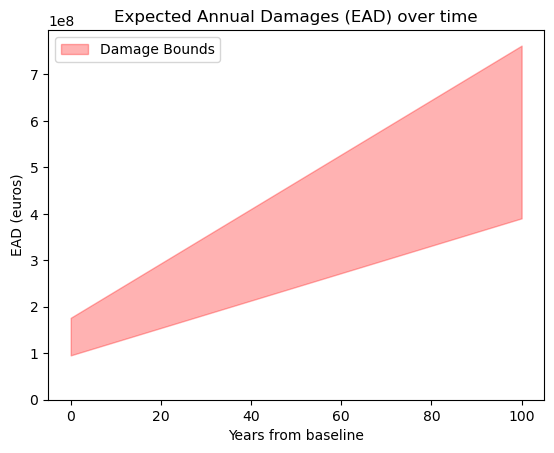

In [11]:
# Define the baseline return periods 
"""
Return period definitions for Rhineland Palatinate (DERP) based on the report by Rauthe M, et al. (2020):
_H_=10-25y 
_M_=100y
_L_=200y
"""
return_period_dict = {'_H_': 10,'_M_': 100,'_L_': 200}

# Add climate change: calculate the dynamic return periods based on flat increase factors. 
# This value has been catchment-specific with frequency increasing in some regions and decreasing in others. 
# It is reasonable that in the future, the frequency will continue to change differently by catchment.

increase_factor = {
    '_H_': (1.2+9.0)/2,
    '_M_': (1.2+9.0)/2,
    '_L_': (1.2+9.0)/2 #average of the range (1.2 to 9.0) based on change since 1900
}

num_years = 100
return_periods = calculate_dynamic_return_periods(return_period_dict, num_years, increase_factor)

# Define dictionary to relate return periods to regions, in this case Rheinland Palatinate is used
return_period_dict = {}
return_period_dict['DERP'] = return_periods #TODO: make generic for other regions

# Add the return period column to aggregated_df and sort by return period
aggregated_df['Return Period'] = [return_period_dict['DERP'][index] for index in aggregated_df.index]
aggregated_df = aggregated_df.sort_values('Return Period', ascending=True)

# Calculate the probability of each return period 
aggregated_df['Probability'] = [[1 / x for x in i] for i in aggregated_df['Return Period']]
probabilities = aggregated_df['Probability']
dmgs = []

# Calculate the expected annual damages for each time step using trapezoidal rule for integration
for ts in range(len(probabilities.iloc[0])):    
    dmgs_l = []
    dmgs_u = []

    for rp in range(len(probabilities)-1):
        d_rp= probabilities.iloc[rp][ts] - probabilities.iloc[rp + 1][ts]
        trap_damage_l = 0.5 * (aggregated_df['Total Damage Lower Bound'].iloc[rp] + aggregated_df['Total Damage Lower Bound'].iloc[rp + 1])
        trap_damage_u = 0.5 * (aggregated_df['Total Damage Upper Bound'].iloc[rp] + aggregated_df['Total Damage Upper Bound'].iloc[rp + 1])
        dmgs_l.append(d_rp * trap_damage_l)
        dmgs_u.append(d_rp * trap_damage_u)
    
    # Add the portion of damages corresponding to the tails of the distribution
    # Assumption - considers the damage for return periods higher than the highest return period the same as that of the highest return period
    d0_rp = probabilities.iloc[-1][ts]
    damage_l0 = max(aggregated_df['Total Damage Lower Bound'])
    damage_u0 = max(aggregated_df['Total Damage Upper Bound'])
    dmgs_l.append(d0_rp * damage_l0)
    dmgs_u.append(d0_rp * damage_u0)

    # Assumption - considers that no assets are damaged at a return period of 4 years or lower
    d_end_rp = (1/4)-probabilities.iloc[0][ts]
    damage_l_end = 0.5 * min(aggregated_df['Total Damage Lower Bound'])
    damage_u_end = 0.5 * min(aggregated_df['Total Damage Upper Bound'])
    dmgs_l.append(d_end_rp * damage_l_end)
    dmgs_u.append(d_end_rp * damage_u_end)

    dmgs.append((sum(dmgs_l), sum(dmgs_u)))

ead_by_ts = pd.DataFrame(dmgs, columns=['Total Damage Lower Bound', 'Total Damage Upper Bound'])

print(f'Baseline expected annual damages: {dmgs[0][0]:,.2f} to {dmgs[0][1]:,.2f} EUR')
print(f'Expected annual damages without adaptation by year {num_years}: {dmgs[-1][0]:,.2f} to {dmgs[-1][1]:,.2f} EUR')

ead_by_ts_plot(ead_by_ts)

In [14]:
# Calculate the expected annual damages (EAD)
summed_output = {}
# Iterate over the items in the collect_output dictionary
for hazard_map, asset_dict in collect_output.items():
    # If the hazard_map and hazard_curve combination is not already in the summed_output dictionary, add it with the sum of the current lower and upper bounds
    if hazard_map not in summed_output:
        summed_output[hazard_map] = (sum(value[0] for value in asset_dict.values()), sum(value[1] for value in asset_dict.values()))
    # If the hazard_map and hazard_curve combination is already in the summed_output dictionary, add the sum of the current lower and upper bounds to the existing ones
    else:
        summed_output[hazard_map][0] += sum(value[0] for value in asset_dict.values())
        summed_output[hazard_map][1] += sum(value[1] for value in asset_dict.values())

summed_output

{'flood_DERP_RW_H_4326_2080410170': (7040397.55486664, 8389970.603221064),
 'flood_DERP_RW_H_4326_2080410430': (892199.8753125762, 1550965.8918992947),
 'flood_DERP_RW_H_4326_2080410540': (7375999.857053701, 7727634.585769907),
 'flood_DERP_RW_H_4326_2080410660': (5504243.607141398, 6400424.699444689),
 'flood_DERP_RW_H_4326_2080410760': (67939.77604095117, 295071.43115233904),
 'flood_DERP_RW_H_4326_2080411370': (3706407.631635442, 13355041.119988918),
 'flood_DERP_RW_H_4326_2080416200': (371968.07039315416, 588934.6375495153),
 'flood_DERP_RW_H_4326_2080416210': (2223105.2839304516, 5680770.2349705845),
 'flood_DERP_RW_H_4326_2080418600': (6207491.540684264, 18525138.92967371),
 'flood_DERP_RW_H_4326_2080418720': (5020.465788654236, 15926.647411924989),
 'flood_DERP_RW_H_4326_2080418880': (242426.27150063723, 312861.29264710436),
 'flood_DERP_RW_H_4326_2080418890': (11053026.570217393, 12163563.215587078),
 'flood_DERP_RW_H_4326_2080419070': (8523.82544898914, 8523.82544898914),
 'fl

In [17]:
files = [file for file in os.listdir(interim_data_path) if file.endswith('.pkl') and file.startswith('overlay')]
basins_list=list(set([int(file.split('.')[0].split('_')[-1]) for file in files]))
# summed_output  is a dicitonary of with keys as the hazard map names and values as a tuple of the lower and upper bounds of the total damage
# example: {'flood_DERP_RW_H_4326_2080411370': (3706407.631635442, 13355041.119988918),

# for a list of all the basins in the region, retrieve the upper and lower damage bounds for each basin and skip if the basin is not a key in the summed_output dictionary

# create a dictionary of dictionaries with the basin number as the level 1 key, the category (ie "H") as the level 2 key and the upper and lower bounds as the values
basin_dict = {}
for basin in basins_list:
    basin_dict[basin] = {}
    for key in summed_output.keys():
        if str(basin) in key:
            basin_dict[basin][key.split('_RW')[-1][0:3]] = summed_output[key]


aggregated_df_by_basin = {}
ead_by_ts_by_basin = {}

for basin, damage_dict in basin_dict.items():
    if len(damage_dict) == 0:
        continue
    aggregated_df_by_basin[basin] = pd.DataFrame.from_dict(damage_dict, orient='index', columns=['Total Damage Lower Bound', 'Total Damage Upper Bound'])
    aggregated_df_by_basin[basin]['Return Period'] = [return_period_dict['DERP'][index] for index in aggregated_df_by_basin[basin].index]
    aggregated_df_by_basin[basin] = aggregated_df_by_basin[basin].sort_values('Return Period', ascending=True)
    aggregated_df_by_basin[basin]['Probability'] = [[1 / x for x in i] for i in aggregated_df_by_basin[basin]['Return Period']]
    probabilities = aggregated_df_by_basin[basin]['Probability']
    dmgs = []

    for ts in range(len(probabilities.iloc[0])):    
        dmgs_l = []
        dmgs_u = []

        for rp in range(len(probabilities)-1):
            d_rp= probabilities.iloc[rp][ts] - probabilities.iloc[rp + 1][ts]
            trap_damage_l = 0.5 * (aggregated_df_by_basin[basin]['Total Damage Lower Bound'].iloc[rp] + aggregated_df_by_basin[basin]['Total Damage Lower Bound'].iloc[rp + 1])
            trap_damage_u = 0.5 * (aggregated_df_by_basin[basin]['Total Damage Upper Bound'].iloc[rp] + aggregated_df_by_basin[basin]['Total Damage Upper Bound'].iloc[rp + 1])
            dmgs_l.append(d_rp * trap_damage_l)
            dmgs_u.append(d_rp * trap_damage_u)
        
        # Add the portion of damages corresponding to the tails of the distribution
        d0_rp = probabilities.iloc[-1][ts]
        damage_l0 = max(aggregated_df_by_basin[basin]['Total Damage Lower Bound'])
        damage_u0 = max(aggregated_df_by_basin[basin]['Total Damage Upper Bound'])
        dmgs_l.append(d0_rp * damage_l0)
        dmgs_u.append(d0_rp * damage_u0)

        d_end_rp = (1/4)-probabilities.iloc[0][ts]
        damage_l_end = 0.5 * min(aggregated_df_by_basin[basin]['Total Damage Lower Bound'])
        damage_u_end = 0.5 * min(aggregated_df_by_basin[basin]['Total Damage Upper Bound'])
        dmgs_l.append(d_end_rp * damage_l_end)
        dmgs_u.append(d_end_rp * damage_u_end)

        dmgs.append((sum(dmgs_l), sum(dmgs_u)))
    
    ead_by_ts_by_basin[basin] = pd.DataFrame(dmgs, columns=['Total Damage Lower Bound', 'Total Damage Upper Bound'])
    
 


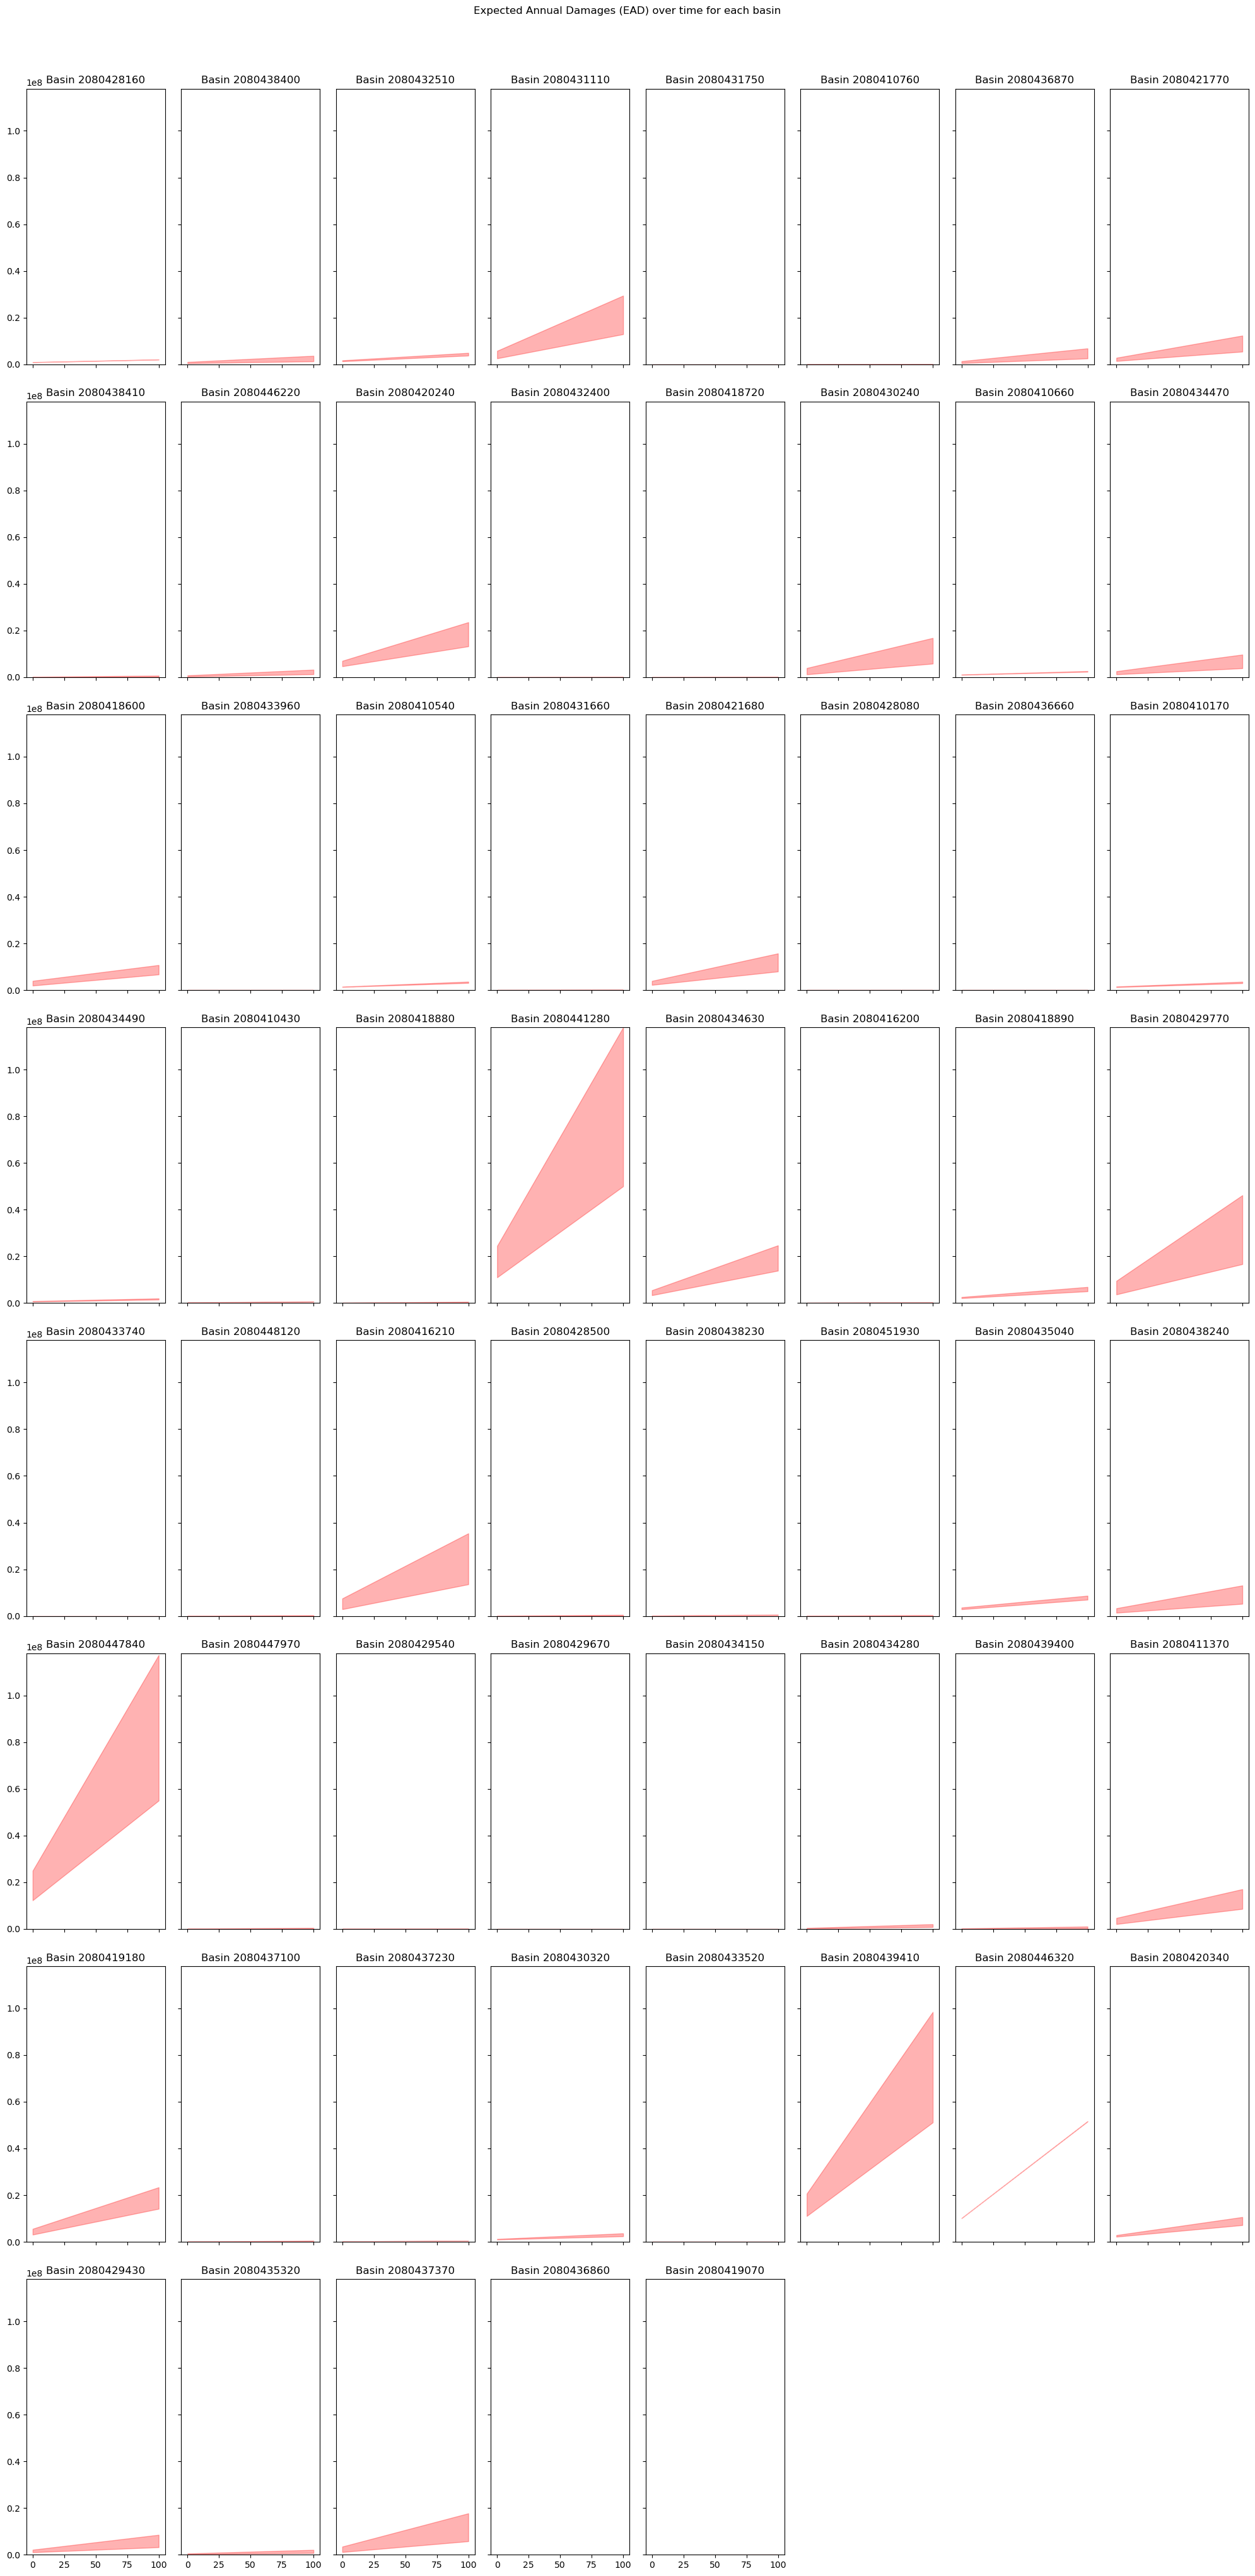

In [22]:
# Calculate the number of rows and columns based on the number of basins
num_basins = len(ead_by_ts_by_basin)
num_cols = int(np.ceil(np.sqrt(num_basins)))
num_rows = int(np.ceil(num_basins / num_cols))

# Create subplots with shared x-axis, the calculated number of rows and columns
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 5*num_rows), sharex=True, sharey=True)

# Flatten axs array for easy iteration
axs = axs.flatten()

max_value = max([ead_by_ts_by_basin[basin]['Total Damage Upper Bound'].max() for basin in ead_by_ts_by_basin.keys()])

for i, basin in enumerate(ead_by_ts_by_basin.keys()):
    axs[i].fill_between(ead_by_ts_by_basin[basin].index, ead_by_ts_by_basin[basin]['Total Damage Lower Bound'], ead_by_ts_by_basin[basin]['Total Damage Upper Bound'], alpha=0.3, color='red')
    axs[i].set_title(f'Basin {basin}')
    axs[i].set_ylim(0, max_value)  # Set y-axis lower limit to 0 and upper limit to max_value

# Hide any unused axes
for j in range(num_basins, num_rows * num_cols):
    axs[j].axis('off')

plt.tight_layout()
plt.suptitle('Expected Annual Damages (EAD) over time for each basin', y=1.02)
plt.show()
